# bivariate copula (bicop)


In [1]:
import sys
import platform
import matplotlib.pyplot as plt
import torch
from torch.special import ndtr
import math
import torchvinecopulib as tvc
from torchvinecopulib.util import _EPS


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"
print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Python: 3.13.3 (main, Apr  8 2025, 13:54:08) [Clang 16.0.0 (clang-1600.0.26.6)]
Platform: macOS-15.4.1-arm64-arm-64bit-Mach-O
PyTorch: 2.7.0
CUDA available: False


# an independent bicop by default


(<class 'torchvinecopulib.bicop.BiCop'>, <class 'torch.nn.modules.module.Module'>, <class 'object'>)


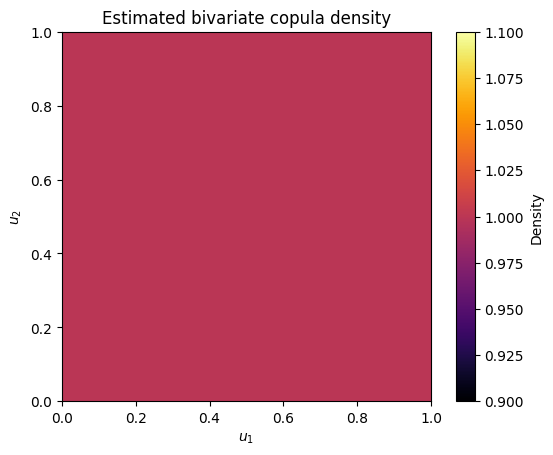

In [2]:
mdl_bcp = tvc.bicop.BiCop(
    # ! num_step_grid has to be a power of 2 !
    num_step_grid=64,
    device=DEVICE,
)
mdl_bcp.imshow()
print(type(mdl_bcp).__mro__)

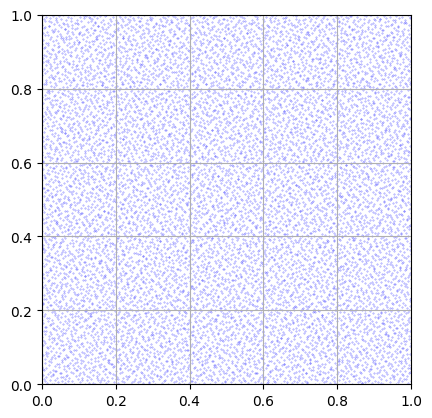

In [3]:
plt.scatter(*mdl_bcp.sample(10000, is_sobol=True).T.cpu(), s=0.1, c="blue", alpha=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
ax = plt.gca()
ax.set_aspect("equal", adjustable="box")

# fitting X


In [4]:
rho = 0.86
V = torch.randn(size=(20000, 2), dtype=torch.float64)
V[:, 1] = rho * V[:, 0] + math.sqrt(1 - rho**2) * V[:, 1]
VV = torch.randn(size=(10000, 2), dtype=torch.float64)
VV[:, 1] = -rho * VV[:, 0] + math.sqrt(1 - rho**2) * VV[:, 1]
V = ndtr(torch.vstack([V, VV])).clamp(_EPS, 1 - _EPS).to(DEVICE)

In [5]:
for f_bidep in tvc.util.ENUM_FUNC_BIDEP:
    print(f"f_bidep: {f_bidep}\t {f_bidep(V[:, 0], V[:, 1])}")

f_bidep: ENUM_FUNC_BIDEP.chatterjee_xi	 0.11609792709350586
f_bidep: ENUM_FUNC_BIDEP.ferreira_tail_dep_coeff	 0.3941474450641316
f_bidep: ENUM_FUNC_BIDEP.kendall_tau	 tensor([0.2185, 0.0000], dtype=torch.float64)
f_bidep: ENUM_FUNC_BIDEP.mutual_info	 0.6883546337889772


In [6]:
mdl_bcp = tvc.bicop.BiCop(
    # ! num_step_grid has to be a power of 2 !
    num_step_grid=128,
    device=DEVICE,
)
mdl_bcp.fit(V, is_tau_est=True)
print(mdl_bcp)

BiCop
{'is_indep': False,
 'num_obs': tensor(30000, dtype=torch.int32),
 'negloglik': tensor(-7444.0617, dtype=torch.float64),
 'num_step_grid': 128,
 'tau': tensor([0.2185, 0.0000], dtype=torch.float64),
 'dtype': torch.float64,
 'device': 'cpu'}


<Axes: title={'center': 'Estimated bivariate copula density'}, xlabel='$u_1$', ylabel='$u_2$'>

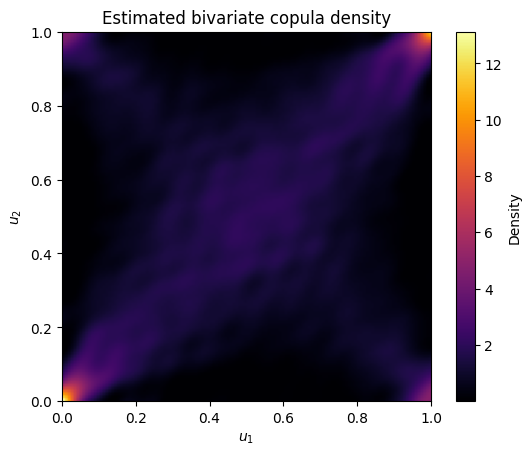

In [7]:
mdl_bcp.imshow()

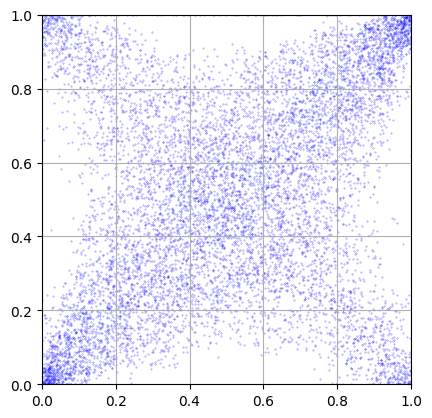

In [10]:
plt.scatter(*mdl_bcp.sample(10000, is_sobol=False).T.cpu(), s=0.1, c="blue", alpha=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
ax = plt.gca()
ax.set_aspect("equal", adjustable="box")

## monotonicity and inv test

- `cdf` non decreasing in horizontal, vertical, diagonal directions
- `hfunc_r` non decreasing in horizontal direction
- `hfunc_l` non decreasing in vertical direction
- `hinv_l(hfunc_l)` is close to raw values
- `hinv_r(hfunc_r)` is close to raw values


In [11]:
grid_U2 = (torch.linspace(_EPS, 1 - _EPS, 100).reshape(-1, 1).repeat(1, 2)).to(
    DEVICE, dtype=torch.float64
)
assert mdl_bcp.cdf(grid_U2).diff(dim=0).min() >= 0
grid_U = (
    torch.linspace(_EPS, 1 - _EPS, 100).reshape(-1, 1).to(DEVICE, dtype=torch.float64)
)
for i in grid_U:
    grid_U2 = torch.hstack([grid_U, i.repeat(100).reshape(-1, 1)])
    assert mdl_bcp.cdf(grid_U2).diff(dim=0).min() >= 0
    assert mdl_bcp.hfunc_r(grid_U2).diff(dim=0).min() >= 0
    grid_U2 = grid_U2.fliplr()
    assert mdl_bcp.cdf(grid_U2).diff(dim=0).min() >= 0
    assert mdl_bcp.hfunc_l(grid_U2).diff(dim=0).min() >= 0
grid_U = torch.linspace(0.1, 0.9, 100).reshape(-1, 1).to(DEVICE, dtype=torch.float64)
for i in grid_U:
    grid_U2 = torch.hstack([grid_U, i.repeat(100).reshape(-1, 1)])
    assert (
        mdl_bcp.hinv_r(torch.hstack([mdl_bcp.hfunc_r(grid_U2), grid_U2[:, [1]]]))
        - grid_U2[:, [0]]
    ).abs().max() < 2e-2
    grid_U2 = grid_U2.fliplr()
    assert (
        mdl_bcp.hinv_l(torch.hstack([grid_U2[:, [0]], mdl_bcp.hfunc_l(grid_U2)]))
        - grid_U2[:, [1]]
    ).abs().max() < 2e-2